# Chapter 8: Unsupervised Methods - Topic Modeling & Clustering

<p>
  <ul>
    <li>LDA - Latent Dirichlet Allocation: A stochastic method for discovering document topics with a lot of flexibility.</li>
    <li>Non negative matrix factorization</li>
    <li>singular-value decomposition (LSI)</li>
  </ul>
</p>

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os

Our dataset for this exercise will be the debate texts from the UN general assembly.
We want to focus on answering the following questions:<br><br>
<b>
    1. what are the speakers are talking about? <br>
    2. Is there a structure in the document corpus? <br>
    3. What are the topics? <br>
    4. Which of them is most prominent? <br>
    5. Does this change over time? 
</b>

In [2]:
#load in dataset
un_path = 'C:\\Users\\fkrasovsky\\OneDrive - Allvue Systems\\Documents\\usd\\msads-509\\Module-2-Data-Prep\\Textbook Exercises\\ungd.csv.gz'
df = pd.read_csv(un_path)
df.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


next, conduct an overview of the **corpus statistics** to figure out if we have nulls, datatypes, etc. We see that speaker and position have null values, but session and year do not so we might use them later.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


We also know that our dataset has formatting differences across speeches, such as how new lines are created (\n) vs. a new line. To split this data into paragraphs, we cannot rely on newline characters, but we can split by the punctuation that occurs at the end of a newline character to get results.

In [17]:
print(repr(df.iloc[2666]["text"][0:200])) #new line here
print(repr(df.iloc[4729]["text"][0:200])) #\n here

'\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General '
'\ufeffOn behalf of the State of Kuwait, it\ngives me pleasure to congratulate Mr. Han Seung-soo,\nand his friendly country, the Republic of Korea, on his\nelection as President of the fifty-sixth session of t'


In [3]:
#split into paragraphs
import re 
df["paragraphs"] = df["text"].map(lambda text: re.split('[.?!]\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)
df.head()

,session,year,country,country_name,speaker,position,text,paragraphs,number_of_paragraphs
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,[33: May I first convey to our President the c...,60
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,[177.\t : It is a fortunate coincidence that p...,50
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,[100.\t It is a pleasure for me to extend to ...,71
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,[155.\t May I begin by expressing to Ambassad...,41
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...","[176. No doubt each of us, before coming up to...",60


### Tracking the change in the number of paragraphs over time
Although the number of speeches doesn't change much year-to-year, we're curious if the number of paragraphs does. This decrease makes sense because the number of speakers increases per year and speaking time becomes limited.

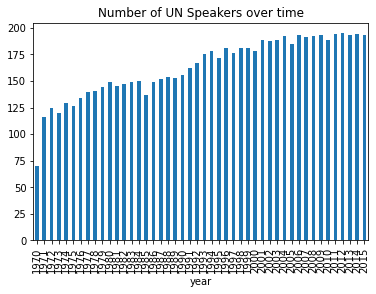

<AxesSubplot:title={'center':'Avgerage number of paragraphs per UN speech over time'}, xlabel='year'>

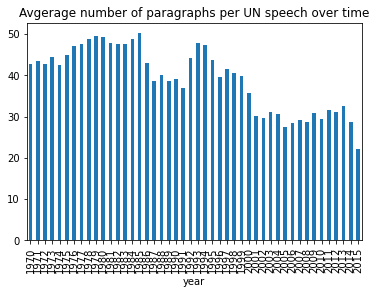

In [4]:
df.groupby('year')['text'].agg('count').plot(kind='bar',title='Number of UN Speakers over time')
plt.show()
df.groupby('year')['number_of_paragraphs'].agg('mean').plot(kind='bar',title='Avgerage number of paragraphs per UN speech over time')

### Preparation
All unsupervised and supervised learning needs vectorized documents, so we start with the TF-IDF and remove stop words to create a sparse matrix for the text. 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
tfidf_text = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
vectors_text = tfidf_text.fit_transform(df['text'])
vectors_text.shape

c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(7507, 24611)

Preprocessing paragraphs is different because we have to flatten the arrays first:

In [6]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame(
    [
        { "text": paragraph, "year": year }
        for paragraphs, year in zip(df["paragraphs"], df["year"])
        for paragraph in paragraphs if paragraph
    ]
)

tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5,max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

(282210, 25165)

#### Nonnegative Matrix Factorization
The easiest way to find a latent structure in a doc matrix is by factorizing it and seeing what's left over. Because a TFIDF matrix always has positive values, we can represent a document matrix as the product of two smaller matrices: V = W * H, where **W has the same number of rows as V and represent the topic mapping for each document, and H shows how the topics are constituted of features.**

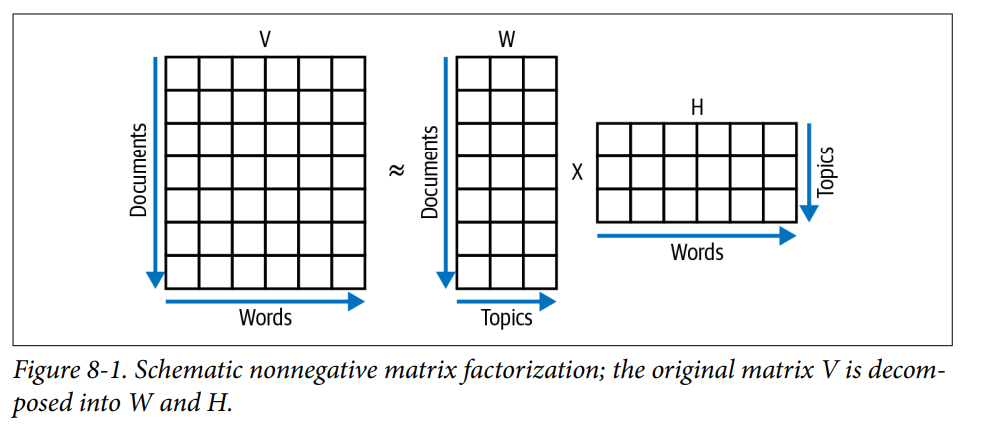

##### Creating a topic model using NMF for Speeches

In [7]:
from sklearn.decomposition import NMF
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(vectors_text)
H_text_matrix = nmf_text_model.components_

c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [8]:
#we can create a function that shows us each topic and what words(features) contribute to each one.
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        
        print("\nTopic %02d" % topic)
        
        for i in range(0, no_top_words):
            print(" %s (%2.2f)" % (features[largest[i]],
            word_vector[largest[i]]*100.0/total))


In [9]:
display_topics(nmf_text_model, tfidf_text.get_feature_names())


Topic 00
 co (0.79)
 operation (0.65)
 disarmament (0.36)
 nuclear (0.34)
 relations (0.25)

Topic 01
 terrorism (0.38)
 challenges (0.32)
 sustainable (0.30)
 millennium (0.29)
 reform (0.28)

Topic 02
 africa (1.15)
 african (0.82)
 south (0.63)
 namibia (0.36)
 delegation (0.30)

Topic 03
 arab (1.02)
 israel (0.89)
 palestinian (0.60)
 lebanon (0.54)
 israeli (0.54)

Topic 04
 american (0.33)
 america (0.31)
 latin (0.31)
 panama (0.21)
 bolivia (0.21)

Topic 05
 pacific (1.55)
 islands (1.23)
 solomon (0.86)
 island (0.82)
 fiji (0.71)

Topic 06
 soviet (0.81)
 republic (0.78)
 nuclear (0.68)
 viet (0.64)
 socialist (0.63)

Topic 07
 guinea (4.26)
 equatorial (1.75)
 bissau (1.53)
 papua (1.47)
 republic (0.57)

Topic 08
 european (0.61)
 europe (0.44)
 cooperation (0.39)
 bosnia (0.34)
 herzegovina (0.30)

Topic 09
 caribbean (0.98)
 small (0.66)
 bahamas (0.63)
 saint (0.63)
 barbados (0.61)


c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##### Creating a topic model using NMF for Paragraphs

In [10]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names())


Topic 00
 nations (5.63)
 united (5.52)
 organization (1.27)
 states (1.03)
 charter (0.93)

Topic 01
 general (2.87)
 session (2.83)
 assembly (2.81)
 mr (1.98)
 president (1.81)

Topic 02
 countries (4.44)
 developing (2.49)
 economic (1.49)
 developed (1.35)
 trade (0.92)

Topic 03
 people (1.36)
 peace (1.34)
 east (1.28)
 middle (1.17)
 palestinian (1.15)

Topic 04
 nuclear (4.93)
 weapons (3.27)
 disarmament (2.01)
 treaty (1.70)
 proliferation (1.46)

Topic 05
 rights (6.49)
 human (6.18)
 respect (1.15)
 fundamental (0.86)
 universal (0.82)

Topic 06
 africa (3.83)
 south (3.32)
 african (1.70)
 namibia (1.38)
 apartheid (1.19)

Topic 07
 security (6.13)
 council (5.89)
 permanent (1.50)
 reform (1.48)
 peace (1.30)

Topic 08
 international (2.05)
 world (1.50)
 community (0.92)
 new (0.77)
 peace (0.67)

Topic 09
 development (4.47)
 sustainable (1.18)
 economic (1.07)
 social (1.00)
 goals (0.93)


c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Singular Value Decomposition
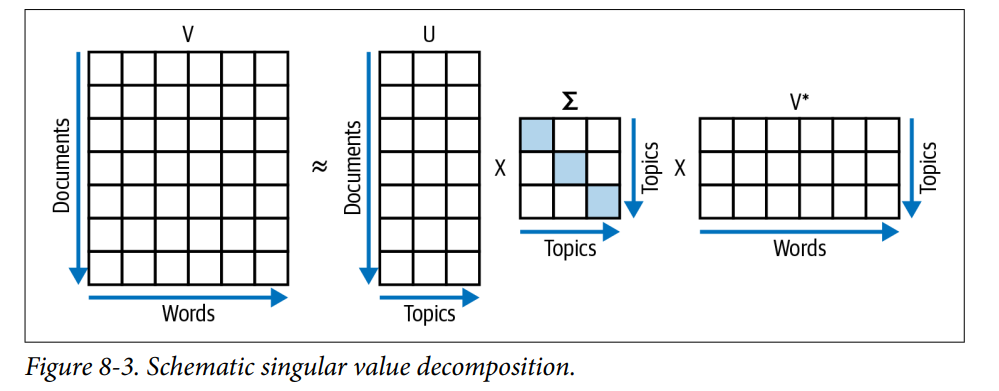

the general purpose of SVD is to rearange a document matrix to uncover a block structure by turning an m x n matrix V into the product of an m x m, n x n, and an m x n matrix containing singular values:

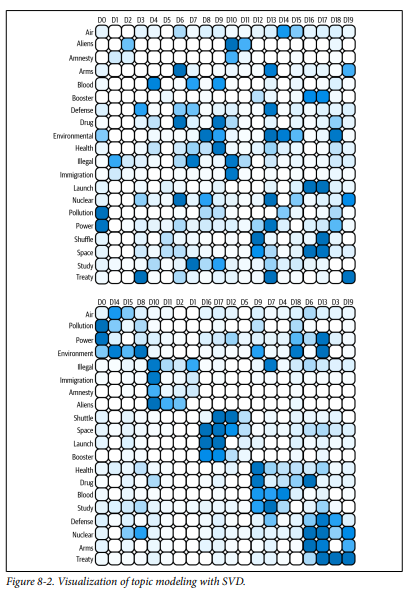

#### Using SVD to Model Paragraphs

In [11]:
from sklearn.decomposition import TruncatedSVD
svd_para_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_
#Our previously defined function for evaluating the topic model can also be used:
display_topics(svd_para_model, tfidf_para_vectorizer.get_feature_names())


Topic 00
 nations (0.67)
 united (0.65)
 international (0.58)
 peace (0.46)
 world (0.46)

Topic 01
 general (-14.04)
 assembly (-13.09)
 session (-12.94)
 mr (-10.02)
 president (-8.59)

Topic 02
 countries (19.15)
 development (14.61)
 economic (13.91)
 developing (13.00)
 session (10.29)

Topic 03
 nations (-4.41)
 united (-4.06)
 development (-0.95)
 organization (-0.84)
 charter (-0.80)

Topic 04
 nuclear (-21.13)
 weapons (-14.01)
 disarmament (-9.02)
 treaty (-7.23)
 proliferation (-6.31)

Topic 05
 rights (29.50)
 human (28.81)
 nuclear (9.20)
 weapons (6.42)
 respect (4.98)

Topic 06
 africa (8.73)
 south (8.24)
 united (3.91)
 african (3.71)
 nations (3.41)

Topic 07
 council (-14.96)
 security (-13.38)
 africa (-8.50)
 south (-6.11)
 african (-3.94)

Topic 08
 world (48.49)
 international (41.03)
 peace (32.98)
 community (23.27)
 africa (22.00)

Topic 09
 development (-63.98)
 sustainable (-20.78)
 peace (-20.74)
 goals (-15.92)
 africa (-15.61)


### Latent Dirichlet Allocation
LDA views each document as consisting of different topics. In other words, each
document is a mix of different topics. In the same way, topics are mixed from words.
To keep the number of topics per document low and to have only a few, important
words constituting the topics, LDA initially uses a Dirichlet distribution, a so-called
Dirichlet prior. This is applied both for assigning topics to documents and for finding
words for the topics. The Dirichlet distribution ensures that documents have only a
small number of topics and topics are mainly defined by a small number of words.

#### LDA for Paragraphs

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#create a vectorizer and fit it with our flattened paragraph df
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])

#create our W and H matrices
lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [14]:
#load our LDA topics - this may take some time.
display_topics(lda_para_model, tfidf_para_vectorizer.get_feature_names())


Topic 00
 africa (2.38)
 people (1.86)
 south (1.57)
 namibia (0.88)
 regime (0.75)

Topic 01
 republic (1.52)
 government (1.39)
 united (1.21)
 peace (1.16)
 people (1.02)

Topic 02
 general (4.22)
 assembly (3.63)
 session (3.38)
 president (2.33)
 mr (2.32)

Topic 03
 human (3.62)
 rights (3.48)
 international (1.83)
 law (1.01)
 terrorism (0.99)

Topic 04
 world (2.22)
 people (1.14)
 countries (0.94)
 years (0.88)
 today (0.66)

Topic 05
 peace (1.76)
 security (1.63)
 east (1.34)
 middle (1.34)
 israel (1.24)

Topic 06
 countries (3.19)
 development (2.70)
 economic (2.22)
 developing (1.61)
 international (1.45)

Topic 07
 nuclear (3.14)
 weapons (2.32)
 disarmament (1.82)
 states (1.47)
 arms (1.46)

Topic 08
 nations (5.50)
 united (5.11)
 international (1.46)
 security (1.45)
 organization (1.44)

Topic 09
 international (1.96)
 world (1.91)
 peace (1.60)
 economic (1.00)
 relations (0.99)


### Visualizing LDA Results interactively

In [16]:
import pyLDAvis.sklearn
lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors,
 count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


### Visualizing LDA Results using Wordclouds

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
         width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
    # if you don't want to save the topic model, comment the next line
    #plt.savefig(f'topic{topic}.png')

In [ ]:
import warnings #turn off warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#NMF Word Clouds
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

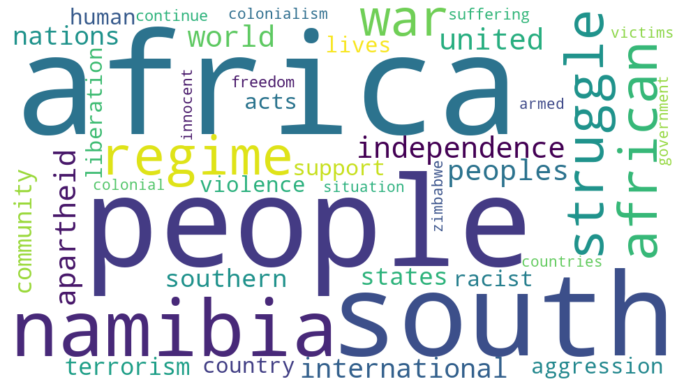

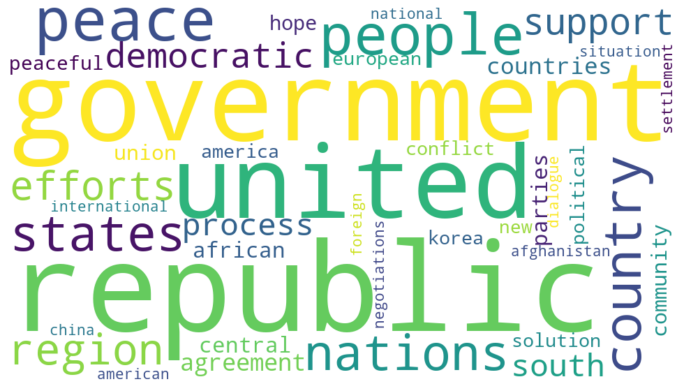

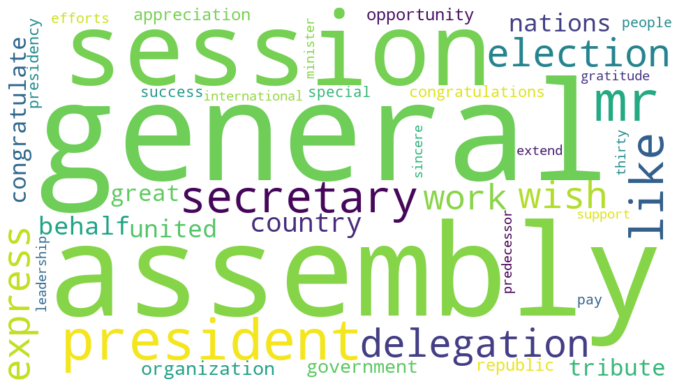

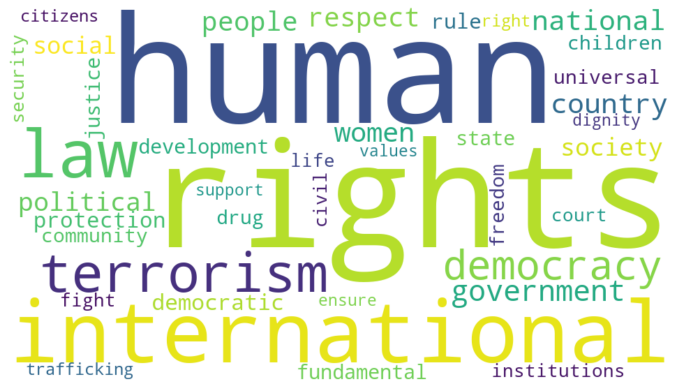

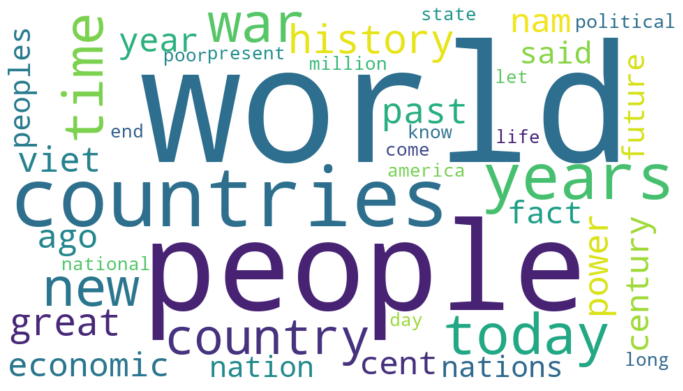

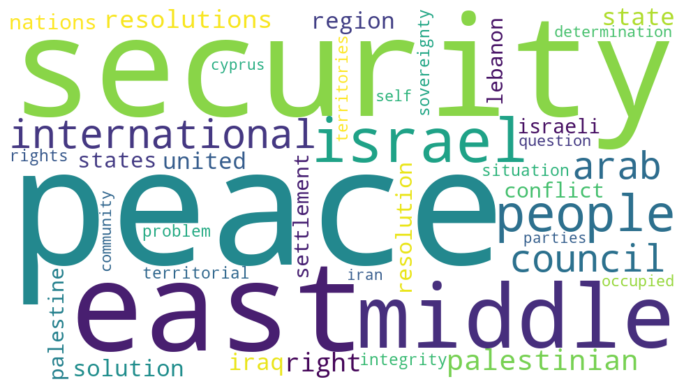

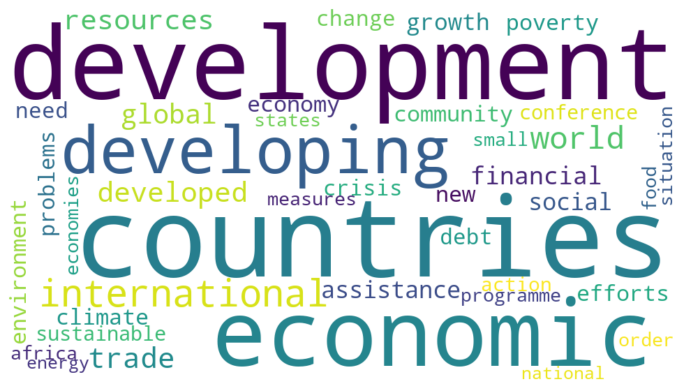

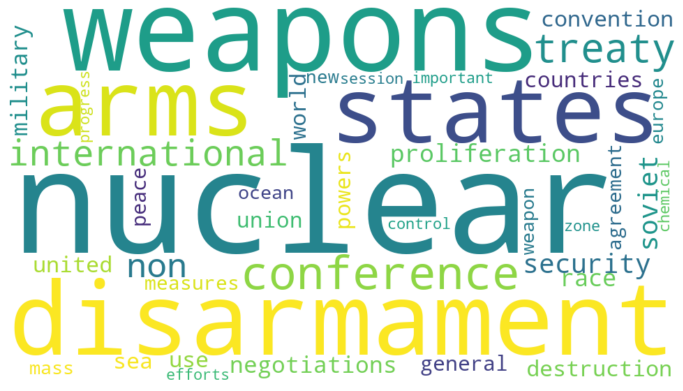

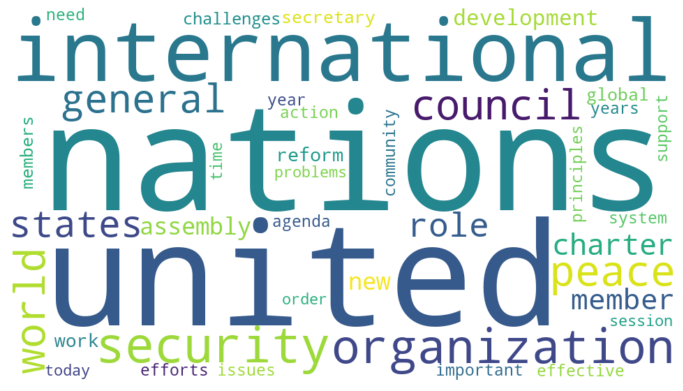

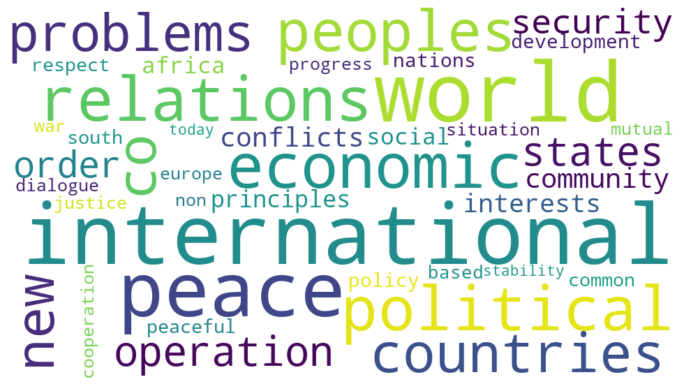

In [22]:
#LDA Word Clouds
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())

### Tracking Changes Over Time

In [30]:
import numpy as np
from tqdm import tqdm
before_1990 = np.array(paragraph_df["year"] < 1990)
after_1990 = ~ before_1990
#Then we can calculate the respective W matrices:
W_para_matrix_early = nmf_para_model.transform(tfidf_para_vectors[before_1990])
W_para_matrix_late = nmf_para_model.transform(tfidf_para_vectors[after_1990])

In [31]:
year_data = []
paragraph_years = paragraph_df['year']
years = np.unique(paragraph_years)
for year in tqdm(years):
    W_year = nmf_para_model.transform(tfidf_para_vectors[paragraph_years == year])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

#To make the plots more intuitive, we first create a list of topics with their two most important words:

topic_names = []
voc = tfidf_para_vectorizer.get_feature_names()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 51.40it/s]
c:\users\fkrasovsky\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:xlabel='year'>

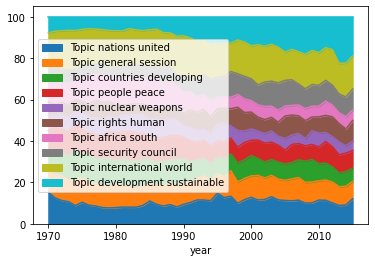

In [32]:
df_year = pd.DataFrame(year_data,
 columns=["year"] + topic_names).set_index("year")
df_year.plot.area()

## Using GenSim for topic modeling
Apart from scikit-learn, Gensim is another popular tool for performing topic model‐
ing in Python. Compared to scikit-learn, it offers more algorithms for calculating
topic models and can also give estimates about the quality of the model.

#### Preparing Data for Genism

In [33]:
# create tokenized documents - genism expects everything to be tokenized and doesn't have its own tokenizer
gensim_paragraphs = [[w for w 
    in re.findall(r'\b\w\w+\b' , paragraph.lower())
    if w not in stopwords]
    for paragraph 
    in paragraph_df["text"]]

In [34]:
#After tokenization, we can initialize the Gensim dictionary with these tokenized
#documents. Think of the dictionary as a mapping from words to columns 
from gensim.corpora import Dictionary
dict_gensim_para = Dictionary(gensim_paragraphs)

In [35]:
#we can also filter out words that show up less than five times or more than 70% of the corpus contains them, similar to min_df and max_df
dict_gensim_para.filter_extremes(no_below=5, no_above=0.7)


#### Calculating Bag of Words with gensim

In [36]:
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

The vectors_gensim_para matrix is the one that we will use for all upcoming topic
modeling tasks with Gensim.

In [38]:
from gensim.models import TfidfModel
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

### Nonnegative Matrix Factorization with Gensim

In [40]:
from gensim.models.nmf import Nmf
nmf_gensim_para = Nmf(vectors_gensim_para, num_topics=10,
 id2word=dict_gensim_para, kappa=0.1, eval_every=5)

In [ ]:
for topic in nmf_gensim_para.print_topics():
    print("\nTopic %02d" % topic[0])
    for terms in topic[1].split(" + "):
        print (re.sub("[^a-zA-Z]","",terms))

### Nonnegative Matrix Factorization - Optimizing with Coherence Score:
This score can be optimized by choosing a different number of clusters until we get the highest value.

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
nmf_gensim_para_coherence = CoherenceModel(
    model=nmf_gensim_para,
    texts=gensim_paragraphs,
    dictionary=dict_gensim_para,
    coherence='c_v'
)

nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()
print(nmf_gensim_para_coherence_score)

### Using LDA with Gensim